<h3>Прогнозирование временных рядов</h3>

__1. Загрузка данных и приведение столбца `date` к формату datetime__

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly as px
import seaborn as sns
from prophet import Prophet
df = pd.read_csv('co2-ppm-daily.csv')
df

c:\Users\setus\OneDrive\Рабочий стол\ds\временные ряды\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,date,value
0,1958-03-30,316.16
1,1958-03-31,316.40
2,1958-04-02,317.67
3,1958-04-03,317.76
4,1958-04-04,317.09
...,...,...
18759,2017-12-27,406.88
18760,2017-12-28,408.26
18761,2017-12-29,407.53
18762,2017-12-30,407.30


In [2]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
value           float64
dtype: object

__2. Визуализация данных__

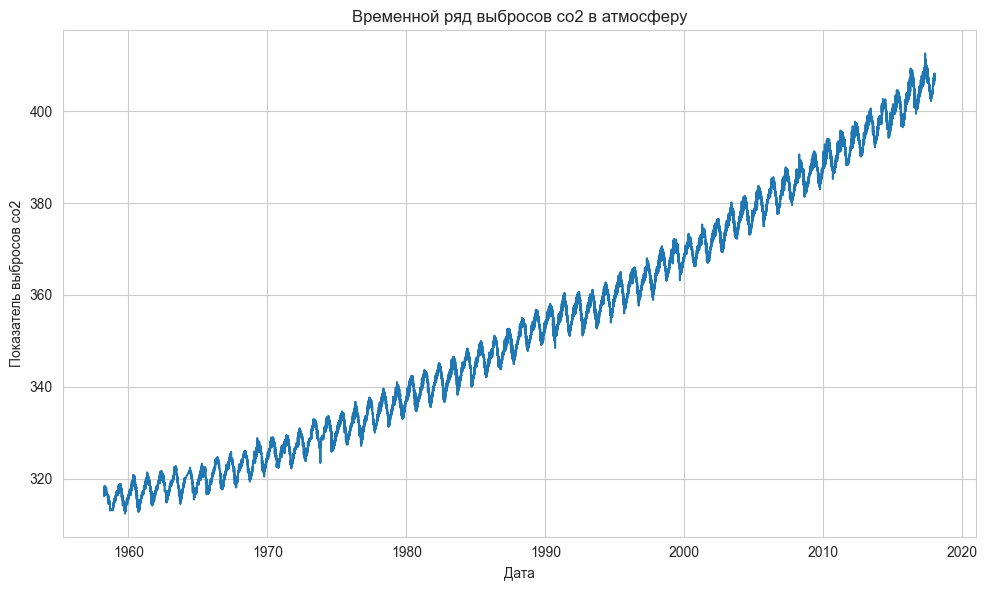

In [3]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='value', data=df)
plt.xlabel('Дата')
plt.ylabel('Показатель выбросов со2')
plt.title('Временной ряд выбросов со2 в атмосферу')

plt.tight_layout()
plt.show()

График илюстрирует динамику выбросов со2 в атмосферу с течением времени. Можно увидеть, устойчивый тренд увеличения выбросов, что указывает на постепенное увеличение уровня со2 в атмосфере с годами.

__3. Прогноз возможных выбросов со2 на ближайшие 2 года__

11:26:23 - cmdstanpy - INFO - Chain [1] start processing
11:26:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\setus\OneDrive\Рабочий стол\ds\временные ряды\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\setus\OneDrive\Рабочий стол\ds\временные ряды\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


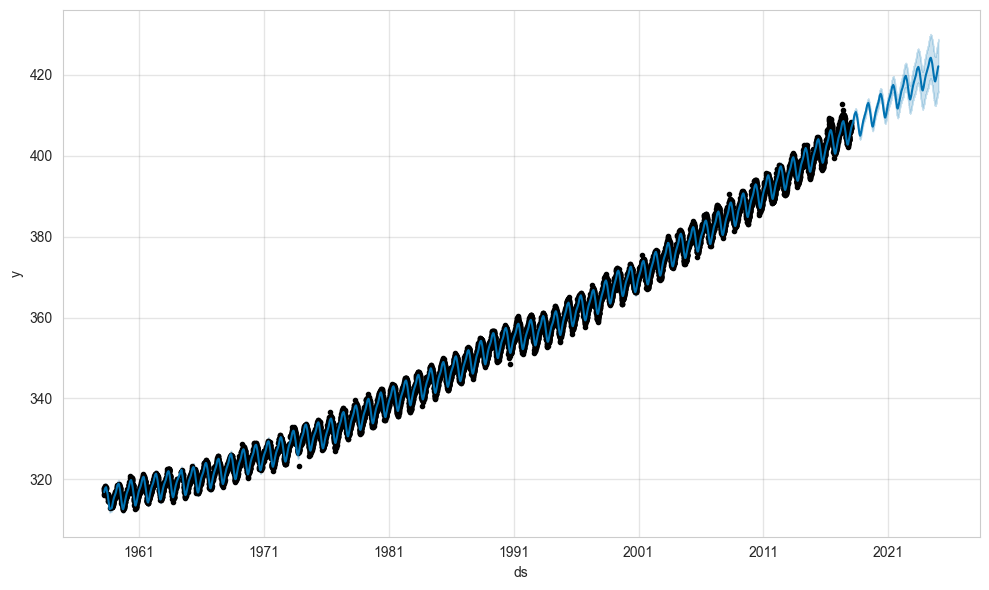

In [17]:
model = Prophet()
df = df.rename(columns={'date': 'ds', 'value': 'y'})
model.fit(df)

future = model.make_future_dataframe(periods=365*7)
forecast = model.predict(future)

fig = model.plot(forecast)

__4. Прогноз на неделю и год__

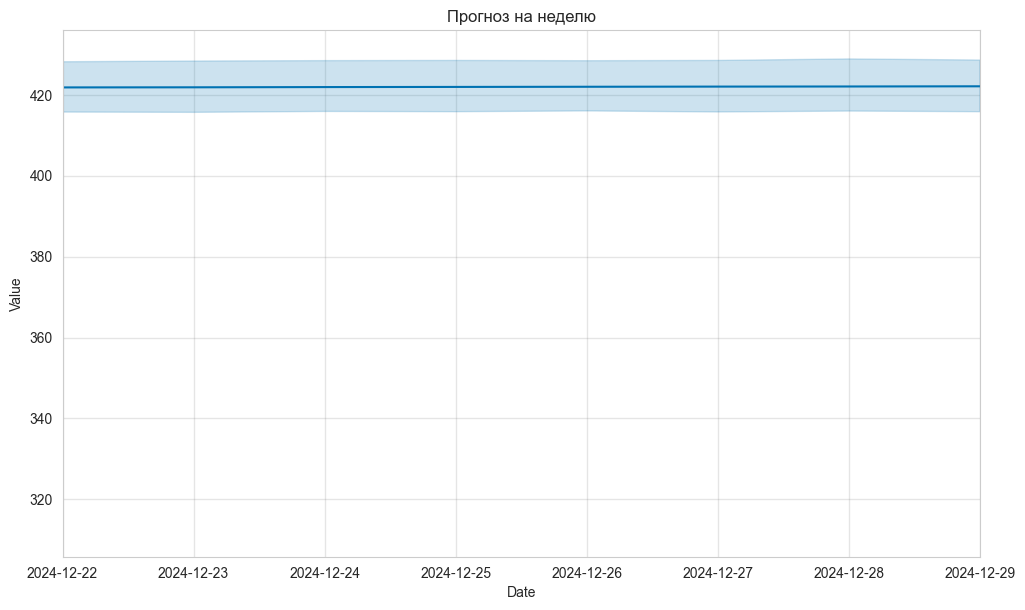

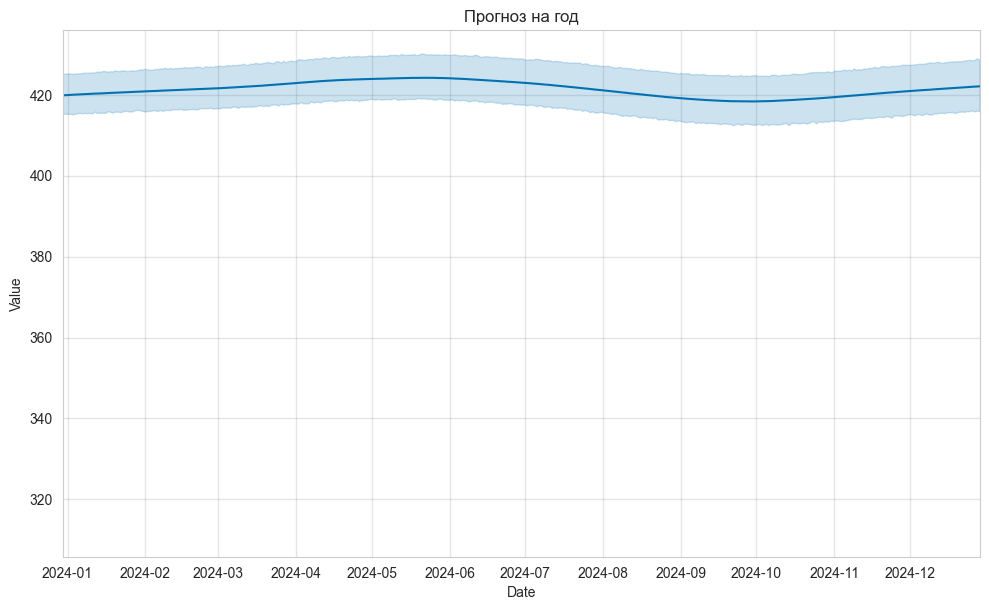

In [18]:
fig = model.plot(forecast, xlabel='Date', ylabel='Value', figsize=(10, 6))
plt.xlim(forecast['ds'].max() - pd.Timedelta(days=7), forecast['ds'].max()) 
plt.title('Прогноз на неделю')
plt.show()

fig = model.plot(forecast, xlabel='Date', ylabel='Value', figsize=(10, 6))
plt.xlim(forecast['ds'].max() - pd.Timedelta(days=365), forecast['ds'].max()) 
plt.title('Прогноз на год')
plt.show()

__5. Прогнозирование с помощью случайного леса и линейной регрессии__


Подготовка данных и обучение моделей:

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

X = df[['year', 'month', 'day']]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
lr_mse = mean_squared_error(y_test, lr_pred)

print(f'MSE rf: {rf_mse}')
print(f'MSE lr: {lr_mse}')


MSE rf: 0.2266061639781516
MSE lr: 13.999110658911304


Прогнозирование показателей со2 на ближайшие два года:

In [13]:
future_dates = pd.date_range(start='2024-05-15', periods=365*2, freq='D') 

future_df = pd.DataFrame({
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day
})

rf_future_pred = rf.predict(future_df)
lr_future_pred = lr.predict(future_df)

future_df['rf_predicted_CO2'] = rf_future_pred
future_df['lr_predicted_CO2'] = lr_future_pred

print(future_df)

     year  month  day  rf_predicted_CO2  lr_predicted_CO2
0    2024      5   15          410.7456        409.762025
1    2024      5   16          410.8806        409.767435
2    2024      5   17          410.2065        409.772846
3    2024      5   18          410.2141        409.778256
4    2024      5   19          410.2720        409.783667
..    ...    ...  ...               ...               ...
725  2026      5   10          409.5152        412.848288
726  2026      5   11          409.6511        412.853698
727  2026      5   12          409.4585        412.859109
728  2026      5   13          409.0259        412.864519
729  2026      5   14          409.3290        412.869930

[730 rows x 5 columns]


Визуализация полученного прогноза

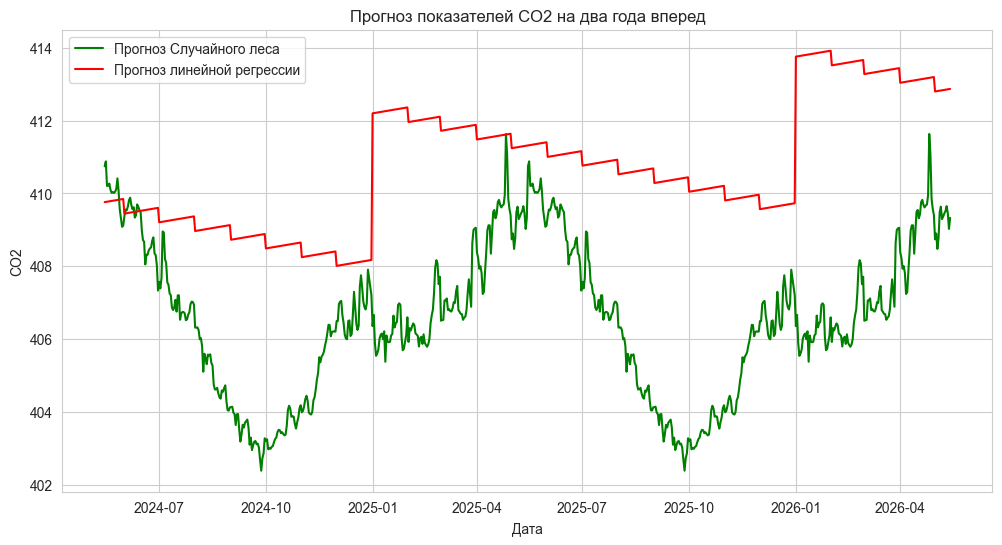

In [16]:
plt.figure(figsize=(12, 6))

plt.plot(future_dates, rf_future_pred, label='Прогноз Случайного леса', color='green')

# Добавление прогнозов LinearRegression
plt.plot(future_dates, lr_future_pred, label='Прогноз линейной регрессии', color='red')

plt.title('Прогноз показателей CO2 на два года вперед')
plt.xlabel('Дата')
plt.ylabel('CO2')
plt.legend()
plt.grid(True)
plt.show()